# CNN su Board PYNQ usando hls4ml

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
import PIL
import PIL.Image

## Preparazione del dataset

### Creazione del dataset
Grazie alla funzione di tensorflow tf.keras.utils.image_dataset_from_directory è stato possibile creare due dataset, uno di training e uno di testing, a partire da directory locale.

In totale sono stati utilizzate 30512 immagini, divise in un 80% per il training e un 20% per la fase di validation.

Le classi totali sono 4: 'background', 'normali', 'sfalsati', 'sovrapposti'.

Tutte le immagini hanno formato RGB e dimensione 32x32.

In [ ]:
import pathlib
data_path = "/home/jovyan/passports_dataset/dataset"
data_dir = pathlib.Path(data_path)
image_count = len(list(data_dir.glob('*/*.png')))
print("Numero immagini training: ", image_count)

In [ ]:
img_size = PIL.Image.open(str(list(data_dir.glob('normali/*'))[0])).size
img_height = img_size[1]
img_width = img_size[0]
input_shape = (img_size[1], img_size[0], 3) 
batch_size = 1024
print(input_shape) 

ds_train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='categorical',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_size = len(ds_train.file_paths)
print(train_size)

ds_val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='categorical',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

n_classes = len(ds_train.class_names)
print(ds_train.class_names)
print("numero classi:" + str(n_classes))

### Preprocessing delle immagini
Una volta caricato il dataset, è stata effettuata un'operazione di normalizzazione delle immagini, grazie alla funzione preprocess.

In [ ]:
def preprocess(image, label, nclasses=4):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
    
train_data = ds_train.map(preprocess, n_classes)  # Get dataset as image and one-hot encoded labels, divided by max RGB
train_data = train_data.shuffle(4096).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess, n_classes)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

np.save('classes.npy', ds_train.class_names)

## Definizione del modello

Viene creato un modello a partire dai dati di training. 

Il modello costruito è costituito da tre livelli di convoluzione, ognuno seguito da un livello di normalizzazione, di attivazione e di pooling. Successivamente, è presente un livello Flatten, che "appiattisce" l'output di questi livelli prima di passare per due livelli densi, ognuno seguito da un livello di normalizzazione e di attivazione. Infine, viene inserito un ultimo livello denso e uno di attivazione.

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

In [ ]:
filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i),
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

## Pruning dei livelli
Per poter inserire il modello nella Board PYNQ, passando dalla generazione del bitstream tramite Vivado, viene effettuata un’operazione di pruning aware
training dei livelli di convoluzione e densi mirando ad un valore di sparsità circa del 50%, riducendo così la complessità del modello,
eliminando le connessioni meno importanti o meno utilizzate. 

Questo viene fatto forzando alcuni pesi del modello a zero, rendendo cosı̀ le corrispondenti matrici dei pesi sparse (matrici in cui quasi tutti i valori sono pari a zero).

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))


# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer


model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

## Training del modello

L’addestramento viene eseguito minimizzando la categorical crossentropy loss utilizzando l’ottimizzatore Adam. 

Il tasso di apprendimento ottimale viene impostato inzialmente a 0.003. Se non vi è alcun miglioramento nella perdita per cinque epoche, il tasso di apprendimento viene ridotto del 90% fino a raggiungere un tasso di apprendimento minimo di $10^{−6}$.

Per evitare overfitting, viene attivato l’early stopping quando non viene osservato alcun miglioramento
nella funzione di perdita per dieci epoche consecutive.

Il numero di epoche impiegato per il training è di 30, train data è il dataset di
training.

In [ ]:
train = True  # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 30

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = model_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))

    model_pruned.save('pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

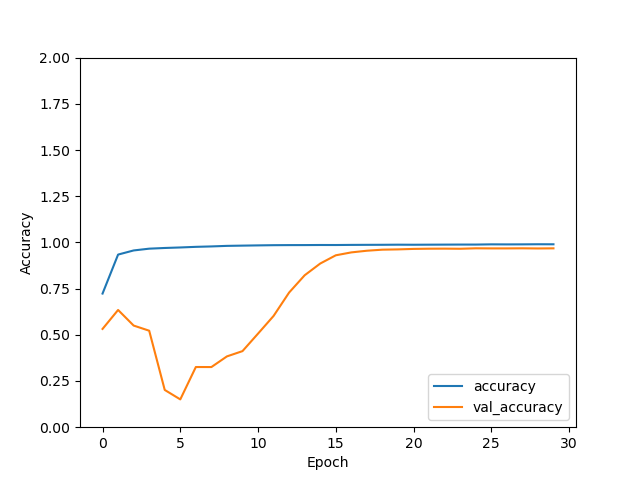

Successivamente, è stato inserito un codice di controllo della sparsity per ciascun livello.

In [ ]:
def doWeights(model):
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
            continue
        weights = layer.weights[0].numpy().flatten()
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10, 10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38, model._name, wrap=True, horizontalalignment='left', verticalalignment='center')
    plt.savefig('sparsity.png')


doWeights(model_pruned)

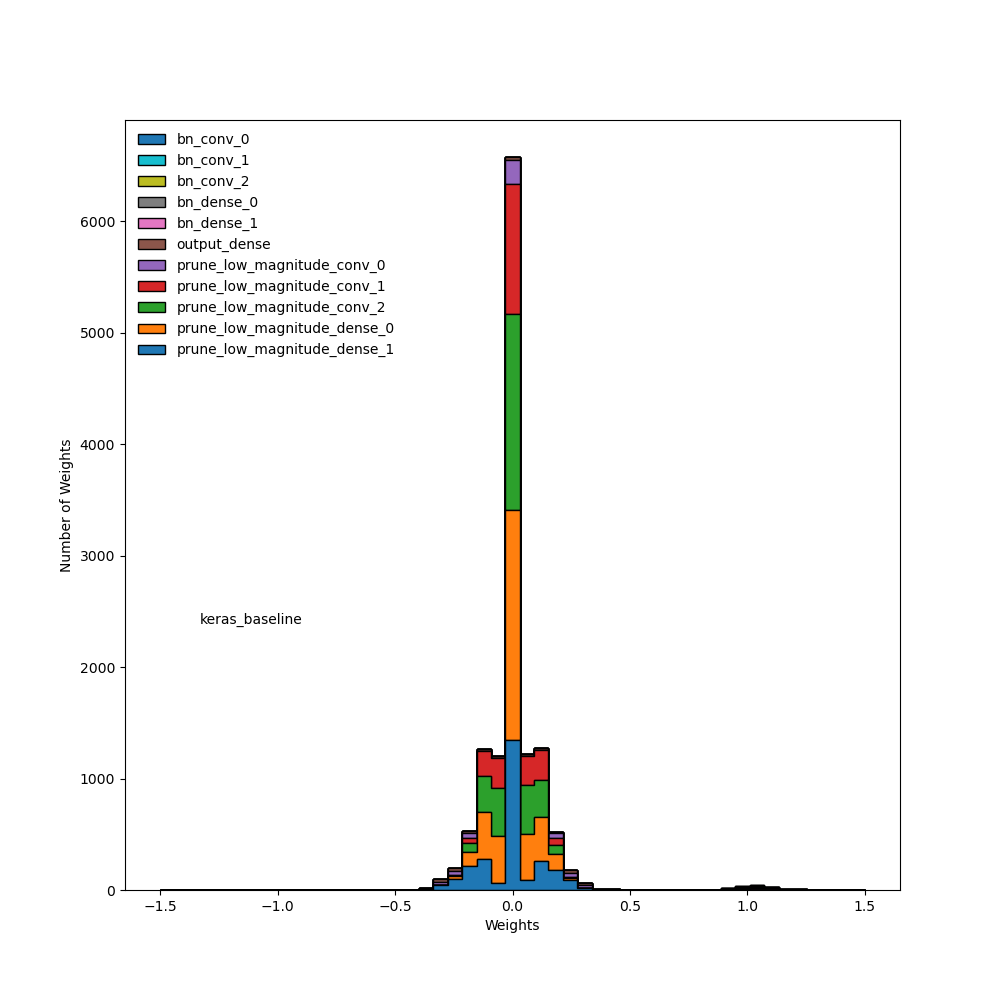

## CNN in hls4ml

A seguito del training della rete, ottenendo un modello tf.keras.Model si è proceduto alla conversione in un bitstream.

Per effettuare questa conversione utilizzando hls4ml si deve derivare un file di configurazione (che verrà utilizzato per passare delle direttive a Vivado) dal
modello di rete scelto.

In [ ]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)
model = strip_pruning(model)

Dato che il bitstream doveva essere caricato su PYNQ, che ha un dispositivo FPGA di piccole dimensioni, è stato necessario aggiungere delle direttive
che permettessero di poter ottenere una descrizione hardware adeguata, come aumentare il ReuseFactor, ovvero un meccanismo della libreria hls4ml
che serve a specificare quante volte devono essere riutilizzati i moltiplicatori sul dispositivo, se viene settato a 1 c’è parallelismo massimo. 

Per creare un bitstream ad hoc per la board PYNQ è necessario un apposito backend denominato "VivadoAccelerator”, successivamente si può procedere
alla compilazione del progetto hls tramite hls model.compile().

In [ ]:
import hls4ml
import plotting

# First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here we set the strategy for a layer to 'resource'
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'

# Setting the Reuse Factor for each layer
hls_config['LayerName']['conv_0']['ReuseFactor'] = 108
hls_config['LayerName']['conv_1']['ReuseFactor'] = 144
hls_config['LayerName']['conv_2']['ReuseFactor'] = 144
hls_config['LayerName']['dense_0']['ReuseFactor'] = 96
hls_config['LayerName']['dense_1']['ReuseFactor'] = 84
hls_config['LayerName']['output_dense']['ReuseFactor'] = 128

hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='VivadoAccelerator')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'pruned_cnn/'

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

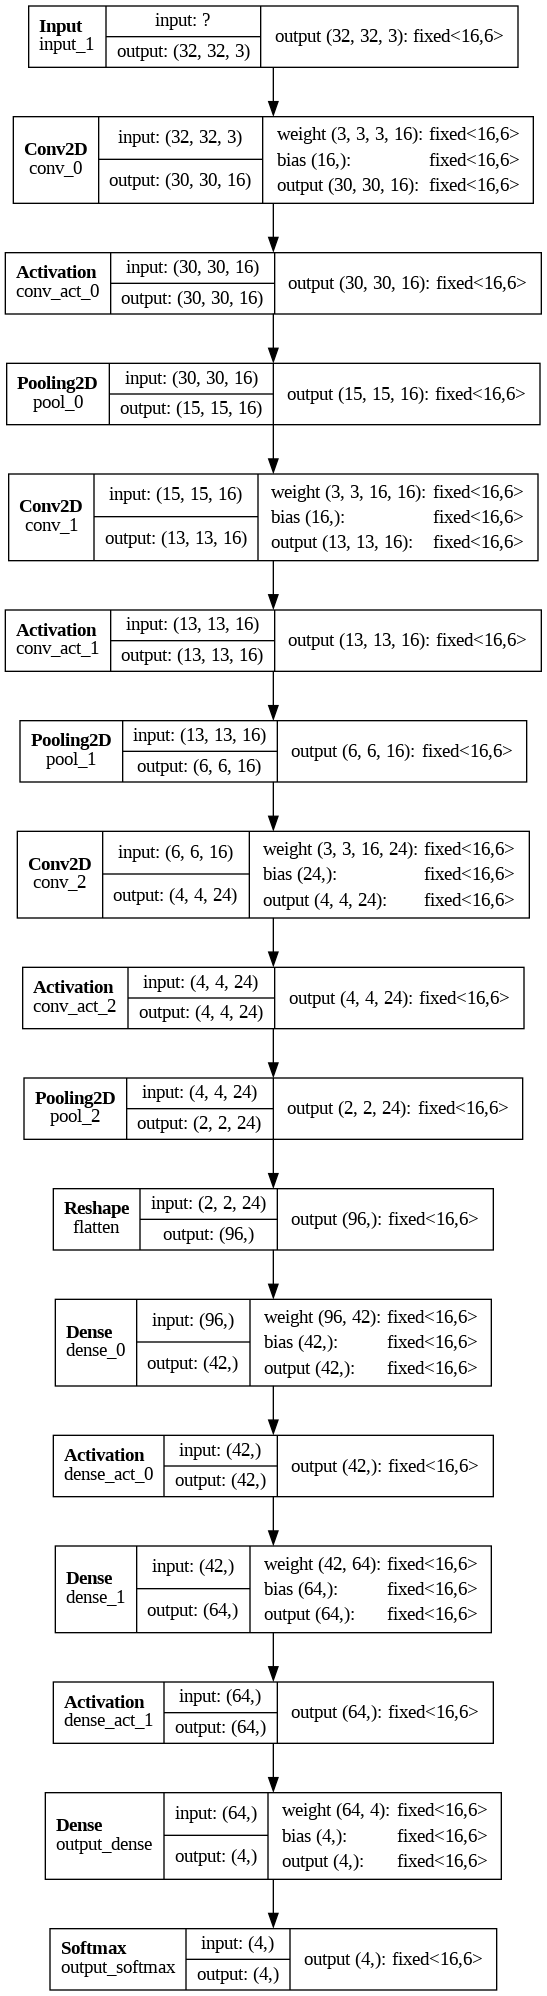

Se la compilazione ha successo, con la chiamata a funzione hls model.build() si può passare ad eseguire il building del bitstream e alla generazione opzionale
di un overlay per gestire i componenti FPGA.

In [ ]:
import os

os.environ['LD_PRELOAD'] = '/lib/x86_64-linux-gnu/libudev.so.1'
os.environ['XILINX_VIVADO']="/opt/Xilinx/Vivado/2019.2"
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

hls_model.build(csim=False, export=True, bitfile=True)

Una volta terminata la compilazione, analizzando il log di Vivado, si possono
rilevare le percentuali di utilizzazione dei componenti hardware all’interno
della FPGA.

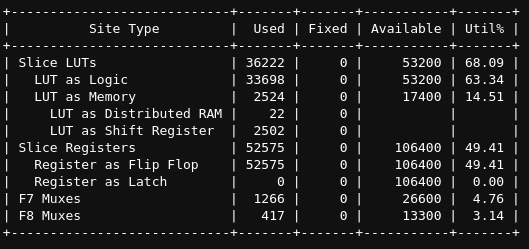

A questo punto, viene utilizzato il bitstream per configurare la Board Pynq secondo il nostro modello.